In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qn '/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/yolo_plate_ocr_dataset.zip'
!unzip -qn '/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/yolo_plate_dataset.zip'

In [3]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection import MeanAveragePrecision
import torchvision

In [5]:
class PlateDetectionDataset(Dataset):
  def __init__(self, images_folder, labels_folder, transform=None):
    super(PlateDetectionDataset, self).__init__()

    self.images_folder = images_folder
    self.labels_folder = labels_folder
    self.transform = transform

    self.image_files = sorted(os.listdir(self.images_folder))

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, index):
    image_file = self.image_files[index]
    label_file = os.path.join(self.labels_folder, image_file[:-4] + '.txt')

    image = Image.open(os.path.join(self.images_folder, image_file))
    image_width, image_height = image.size

    image = np.array(image, dtype='float32') / 255.0
    target = self.get_target(label_file, image_width, image_height)

    if self.transform:
      augmented = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])
      image = augmented['image']
      target['boxes'] = torch.tensor(augmented['bboxes'], dtype=torch.float)
      target['labels'] = torch.tensor(augmented['labels'])

    return image, target

  def xywh_to_xyxy(self, box, image_width, image_height):
    category = int(box[0])

    x1 = int((float(box[1]) - float(box[3])/2)* image_width)
    y1 = int((float(box[2]) - float(box[4])/2) *image_height)
    x2 = x1 + int(float(box[3]) * image_width)
    y2 = y1 + int(float(box[4]) * image_height)

    # x1 = float(box[1]) - float(box[3])/2
    # y1 = float(box[2]) - float(box[4])/2
    # x2 = x1 + float(box[3])
    # y2 = y1 + float(box[4])

    return [category, x1, y1, x2, y2]

  def get_target(self, label_file, image_width, image_height):
    with open(os.path.join(self.labels_folder, label_file), 'r') as f:
      boxes = f.readlines()

    target = {}
    labels = []
    bboxes = []

    for box in boxes:
      box = box[:-2].split()
      box = self.xywh_to_xyxy(box, image_width, image_height)
      labels.append(box[0] + 1) #for resnet50 classes start with 1, not 0
      bboxes.append(box[1:])

    if len(bboxes) == 0:
      bboxes.append([0, 0, image_width,image_height])
      labels.append(0)
    target['boxes'] = bboxes
    target['labels'] = labels

    return target

In [6]:
class PlateOCRDataset(Dataset):
  def __init__(self, images_folder, labels_folder, transform=None):
    self.images_folder = images_folder
    self.labels_folder = labels_folder
    self.transform = transform

    self.image_files = sorted(os.listdir(self.images_folder))

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, index):
    image_file = self.image_files[index]
    label_file = os.path.join(self.labels_folder, image_file[:-4] + '.txt')

    image = Image.open(os.path.join(self.images_folder, image_file))
    image_width, image_height = image.size

    image = np.array(image, dtype='float32') / 255.0
    target = self.get_target(label_file, image_width, image_height)

    if self.transform:
      augmented = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])
      image = augmented['image']
      target['boxes'] = torch.tensor(augmented['bboxes'], dtype=torch.float)
      target['labels'] = torch.tensor(augmented['labels'])

    return image, target

  def xywh_to_xyxy(self, box, image_width, image_height):
    category = int(box[0])

    x1 = int((float(box[1]) - float(box[3])/2)* image_width)
    y1 = int((float(box[2]) - float(box[4])/2) *image_height)
    x2 = x1 + int(float(box[3]) * image_width)
    y2 = y1 + int(float(box[4]) * image_height)

    # x1 = float(box[1]) - float(box[3])/2
    # y1 = float(box[2]) - float(box[4])/2
    # x2 = x1 + float(box[3])
    # y2 = y1 + float(box[4])

    return [category, x1, y1, x2, y2]

  def get_target(self, label_file, image_width, image_height):
    with open(os.path.join(self.labels_folder, label_file), 'r') as f:
      boxes = f.readlines()

    target = {}
    labels = []
    bboxes = []

    for box in boxes:
      box = box[:-2].split()
      box = self.xywh_to_xyxy(box, image_width, image_height)
      labels.append(box[0] + 1) #for resnet50 classes start with 1, not 0
      bboxes.append(box[1:])

    if len(bboxes) == 0:
      bboxes.append([0, 0, image_width,image_height])
      labels.append(0)
    target['boxes'] = bboxes
    target['labels'] = labels

    return target

In [27]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [7]:
plate_detection_test_transform = A.Compose(
    [
        # A.Resize(height=224, width=224),
        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']
    )
)

plate_ocr_test_transform = A.Compose(
    [
      A.Resize(224, 224),
      ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']
    )
)

In [8]:
df_test_plate_detection = PlateDetectionDataset('/content/yolo_plate_dataset/images/test', '/content/yolo_plate_dataset/labels/test', transform=plate_detection_test_transform)
df_test_plate_ocr = PlateOCRDataset('/content/yolo_plate_ocr_dataset/images/test', '/content/yolo_plate_ocr_dataset/labels/test', transform=plate_ocr_test_transform)

In [28]:
plate_detection_test_loader = DataLoader(df_test_plate_detection, batch_size=8, shuffle=True, collate_fn=collate_fn)
plate_ocr_test_loader = DataLoader(df_test_plate_ocr, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [10]:
model_plate_detection = torch.load('/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/att1_epoch5.pt')
model_plate_ocr = torch.load('/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models_number/att1_epoch8.pt')

In [156]:
from torchvision.utils import draw_bounding_boxes
def apply_nms(preds, score_threshold, iou_threshold):
  for pred in preds:
    boxes, scores, labels = pred['boxes'], pred['scores'], pred['labels']
    indices = torch.nonzero(scores > score_threshold).squeeze(1)
    boxes = boxes[indices]
    scores = scores[indices]
    labels = labels[indices]

    indices = torchvision.ops.nms(boxes, scores, iou_threshold)
    pred['boxes'] = boxes[indices]
    pred['scores'] = scores[indices]
    pred['labels'] = labels[indices]
  return preds

def save_cropped_boxes(image, boxes, folder_path, image_path):
    os.makedirs(folder_path, exist_ok=True)
    for i, box in enumerate(boxes):
        ymin, xmin, ymax, xmax = box.tolist()
        image_copy = image.clone()
        image_copy = Image.fromarray(image_copy.permute(1, 2, 0).numpy())
        cropped_box = image_copy.crop((ymin, xmin, ymax, xmax))
        cropped_box.save(os.path.join(folder_path, image_path + f"_cropped_box_{i}.png"))

def plot_image_boxes(images, outputs):
  outputs = apply_nms(outputs, 0.7, 0.5)
  fig, ax = plt.subplots(4, 2, figsize=(15, 20))

  for i in range(4):
    image0 = (images[2*i]*255).to(torch.uint8).cpu()
    image1 = (images[2*i+1]*255).to(torch.uint8).cpu()
    boxes0 = (outputs[2*i]['boxes']).to(torch.int).cpu()
    boxes1 = (outputs[2*i+1]['boxes']).to(torch.int).cpu()
    labels0 = outputs[2*i]['labels'].cpu().numpy().astype(str)
    labels1 = outputs[2*i+1]['labels'].cpu().numpy().astype(str)

    save_cropped_boxes(image0, boxes0, '/content/boxes', f"image_{2*i}")
    save_cropped_boxes(image1, boxes1, '/content/boxes', f"image_{2*i+1}")


    ax[i, 0].imshow(draw_bounding_boxes(image0, boxes0, labels0, colors='red').permute(1, 2, 0))
    ax[i, 0].axis('off')
    ax[i, 1].imshow(draw_bounding_boxes(image1, boxes1, labels1, colors='red').permute(1, 2, 0))
    ax[i, 1].axis('off')

  plt.tight_layout()
  plt.show()

In [157]:
## When you start running after this cell, you get 8 test images
## then, their license plates are cut to be further used for the inference using the second model
## finally, you get symbols labeled

In [164]:
images, labels = next(iter(plate_detection_test_loader))

In [165]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [166]:
images = [image.to(device) for image in images]
labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

model_plate_detection.eval()
with torch.no_grad():
  outputs = model_plate_detection(images)

plot_image_boxes(images, outputs)

Output hidden; open in https://colab.research.google.com to view.

In [167]:
class CroppedImagesDataset(Dataset):
  def __init__(self, folder_path, transform=None):
    self.folder_path = folder_path
    self.image_files = sorted([file for file in os.listdir(self.folder_path) if os.path.isfile(os.path.join(self.folder_path, file))])
    self.transform = transform

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, index):
    image_file = self.image_files[index]

    image = Image.open(os.path.join(self.folder_path, image_file))
    image = np.array(image, dtype='float32') / 255.0

    if self.transform:
      augmented = self.transform(image=image)
      image = augmented['image']
    return image

In [168]:
cropped_images_transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

In [169]:
df_cropped = CroppedImagesDataset('/content/boxes', cropped_images_transform)
loader_cropped = DataLoader(df_cropped, batch_size=8, shuffle=True)

In [170]:
#add class names instead of numbers
letters = {}
for i in range(0, 10):
  letters[str(i+1)] = str(i)

for i in range(ord('A'), ord('Z') + 1):
  letters[str(i - ord('A') + 11)] = chr(i)

In [171]:
def sort_boxes(boxes: torch.Tensor, labels: torch.Tensor):
  combined_data = list(zip(boxes.tolist(), labels.tolist()))
  sorted_data = sorted(combined_data, key=lambda x: x[0][0] + 2.5 * x[0][1])

  sorted_boxes = [item[0] for item in sorted_data]
  sorted_labels = [item[1] for item in sorted_data]

  sorted_boxes_tensor = torch.tensor(sorted_boxes)
  return sorted_boxes_tensor, sorted_labels

In [172]:
def plot_symbols(images, outputs):
  outputs = apply_nms(outputs, 0.7, 0.5)
  fig, ax = plt.subplots(4, 2, figsize=(15, 20))

  for i in range(4):
    image0 = (images[2*i]*255).to(torch.uint8).cpu()
    image1 = (images[2*i+1]*255).to(torch.uint8).cpu()
    boxes0 = (outputs[2*i]['boxes']).to(torch.int).cpu()
    boxes1 = (outputs[2*i+1]['boxes']).to(torch.int).cpu()
    labels0 = outputs[2*i]['labels'].cpu().numpy().astype(str)
    labels1 = outputs[2*i+1]['labels'].cpu().numpy().astype(str)

    boxes0, labels0 = sort_boxes(boxes0, labels0)
    boxes1, labels1 = sort_boxes(boxes1, labels1)

    for j in range(len(labels0)):
      labels0[j] = letters[labels0[j]]
    for j in range(len(labels1)):
      labels1[j] = letters[labels1[j]]
    # print(boxes0, labels0)
    # print(boxes1, labels1)
    try:
      ax[i, 0].imshow(draw_bounding_boxes(image=image0, boxes=boxes0, labels=labels0, colors='red').permute(1, 2, 0))
      ax[i, 0].axis('off')
      ax[i, 0].set_title(labels0)
      ax[i, 1].imshow(draw_bounding_boxes(image=image1, boxes=boxes1, labels=labels1, colors='red').permute(1, 2, 0))
      ax[i, 1].axis('off')
      ax[i, 1].set_title(labels1)
    except Exception:
      continue

  plt.tight_layout()
  plt.show()

In [173]:
image_plates = next(iter(loader_cropped))
image_plates = image_plates.to(device)

In [174]:
model_plate_ocr.eval()
with torch.no_grad():
  outputs = model_plate_ocr(image_plates)

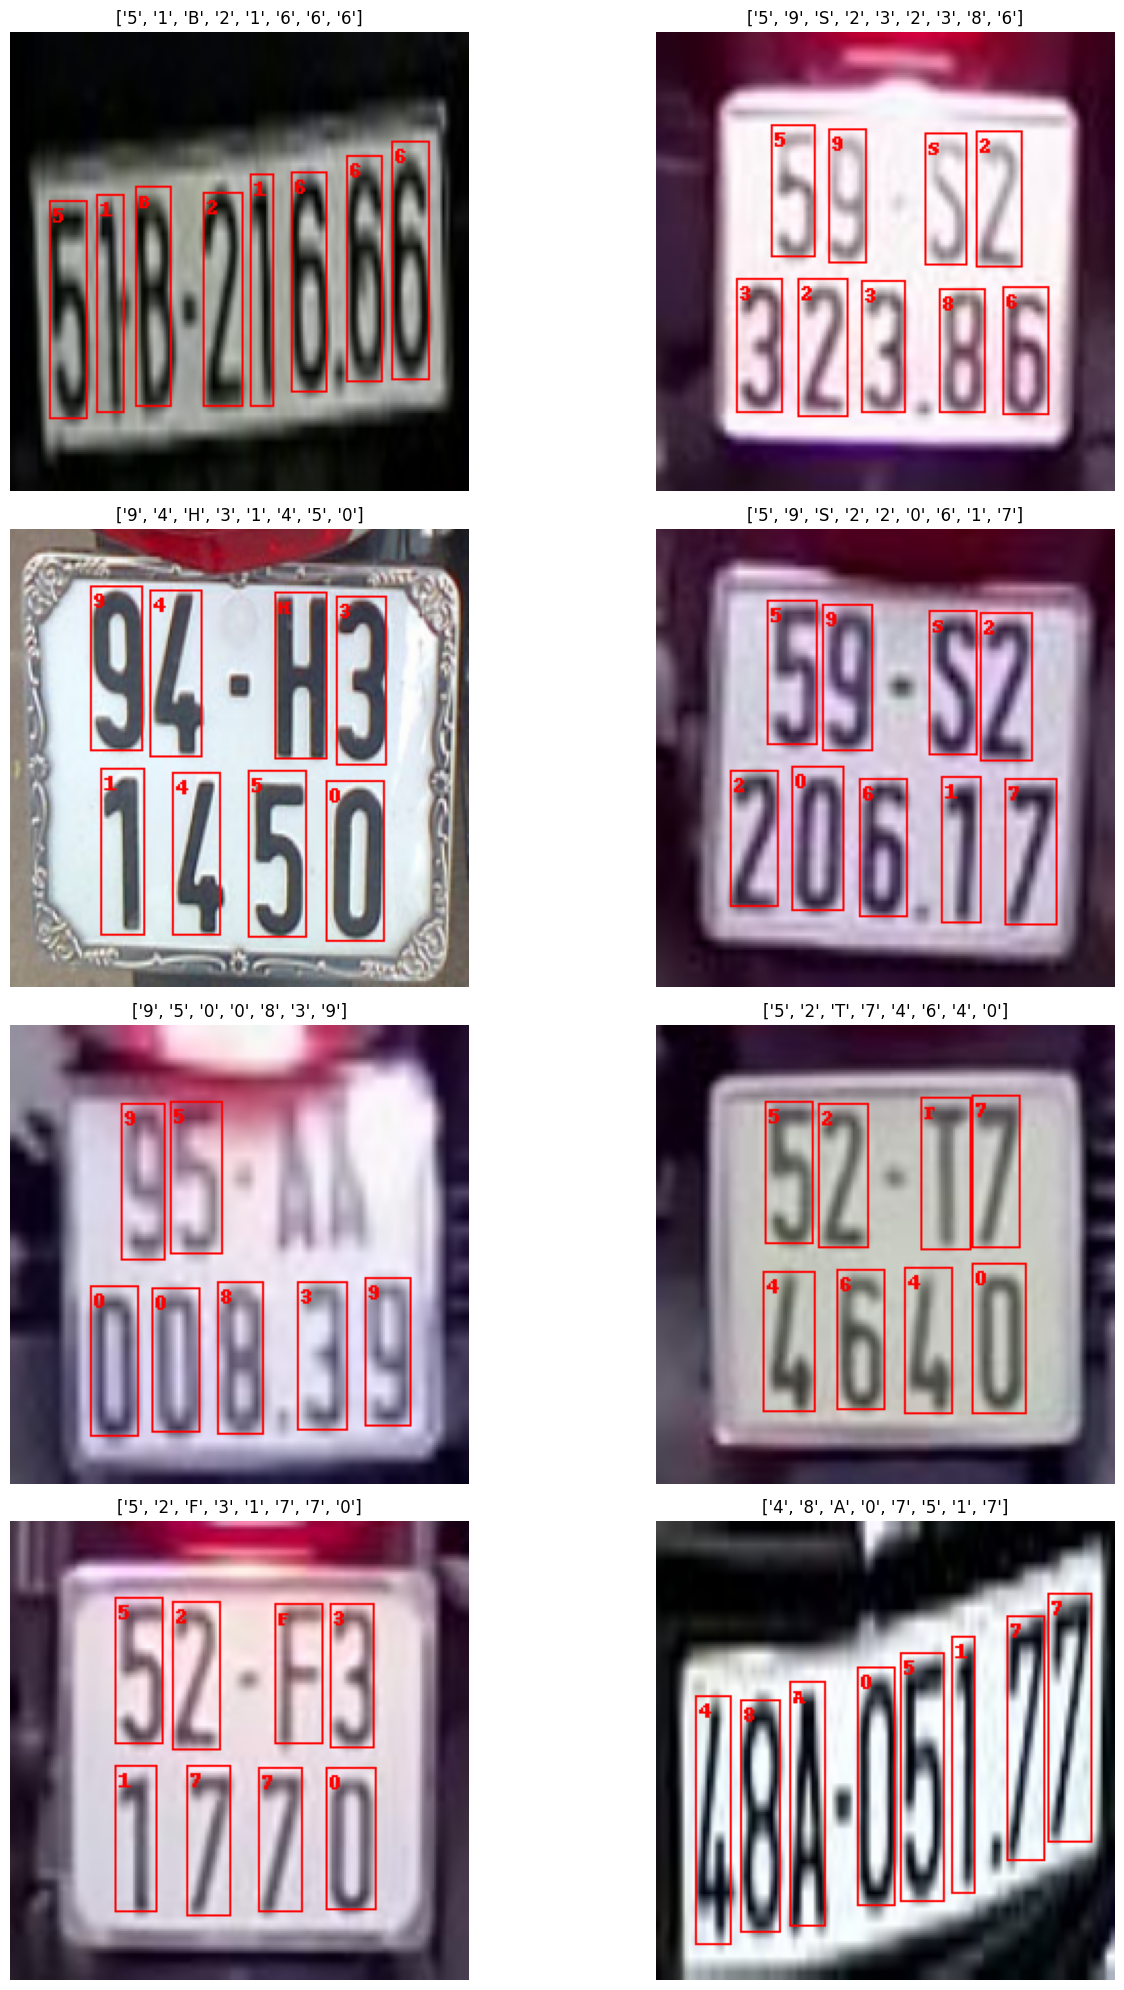

In [175]:
plot_symbols(image_plates, outputs)